In [3]:
%matplotlib inline

In [5]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
db = MongoClient('mongodb-condor.icecube.wisc.edu').condor

In [5]:
print(db.condor_history.find_one({'MATCH_EXP_JOBGLIDEIN_ResourceName':'WIPAC'}))

{'QDate': 1482211515, 'ImageSize_RAW': 2136232, 'NumShadowStarts': 1, 'EnteredCurrentStatus': 1482213600, 'BytesSent': 94082.0, 'ProcId': 0, 'RemoteSysCpu': 2.0, 'ClusterId': 21641819, '_id': ObjectId('58a5c87cdb39d105d185dd9b'), 'ExecutableSize_RAW': 3, 'CumulativeSlotTime': 1355.0, 'RemoteUserCpu': 1209.0, 'ExitStatus': 0, 'JobStatus': 4, 'LastRemoteHost': 'slot1@2635439@e273.chtc.wisc.edu', 'Cmd': '/scratch/simprod/chtc/submit/12604/iceprod_41558.1482211513.996719/iceprod.12604.41558.ic86det0.sh', 'JobStartDate': 1482212245, 'BytesRecvd': 1898944.0, 'CommittedTime': 1355, 'Owner': 'juancarlos', 'RemoteWallClockTime': 1355.0, 'MATCH_EXP_JOBGLIDEIN_ResourceName': 'WIPAC', 'CompletionDate': 1482213600, 'JobCurrentStartDate': 1482212245, 'ExitBySignal': False, 'RequestMemory': 4000, 'RequestDisk': 4000000, 'DiskUsage_RAW': 654694, 'RequestCpus': 1, 'GlobalJobId': 'sub-simprod.icecube.wisc.edu#21641819.0#1482211515', 'ExitCode': 0, 'NumJobStarts': 1, 'AccountingGroup': 'ifThenElse(Reques

In [6]:
sites = {}
fixup = {}
for row in db.condor_history.find(projection=['GlobalJobId','LastRemoteHost','StartdPrincipal','MATCH_EXP_JOBGLIDEIN_ResourceName']):
    if 'LastRemoteHost' not in row:
        continue
    host = row['LastRemoteHost'].split('@')[-1]
    resource_name = row['MATCH_EXP_JOBGLIDEIN_ResourceName'] if 'MATCH_EXP_JOBGLIDEIN_ResourceName' in row else ''
    if '.' in resource_name or 'gzk' in resource_name:
        resource_name = None
    if not resource_name:
        if host not in fixup:
            fixup[host] = []
        fixup[host].append(row['GlobalJobId'])
        continue
    s = row['MATCH_EXP_JOBGLIDEIN_ResourceName']
    if s not in sites:
        sites[s] = set()
    sites[s].add(host)
print('fixup:',len(fixup))
print({s:len(sites[s]) for s in sites})

fixup: 48113
{'UCSDT2': 272, 'NUMEP-OSG': 24, 'NPX': 237, 'UKI-NORTHGRID-MAN-HEP': 101, 'FLTECH': 16, 'Local Job': 462, 'Vanderbilt': 276, 'UKI-LT2-QMUL': 2, 'UNI-DORTMUND': 166, 'HOSTED_STANFORD': 82, 'Tusker': 113, 'SWT2_CPB': 270, 'CA-SCINET-T2': 152, 'LIDO_Dortmund': 393, 'osgconnect': 2913, 'CHTC': 271, 'Sandhills': 100, 'Uppsala': 128, 'Xstream': 1, 'SU-OG': 1752, 'CIT_CMS_T2': 339, 'Hyak': 669, 'BEgrid-ULB-VUB': 152, 'UCD': 32, 'IceCube_DE_Dortmund_udo-ce08': 1, 'wuppertalprod': 181, 'jasper': 50, 'AGLT2': 349, 'Bartol': 32, 'DESY-HH': 264, 'UTA_SWT2': 111, 'xsede-osg': 6534, 'PHIDO_Dortmund': 105, 'SU-OG-CE': 9639, 'Comet': 575, 'Clemson-Palmetto': 887, 'Purdue-Hadoop': 247, 'mainzgrid': 51, 'T2B_BE_IIHE': 58, 'OU_OSCER_ATLAS': 65, 'NWICG_NDCMS': 107, 'BNL-ATLAS': 667, 'SPRACE': 118, 'GPGrid': 889, 'DESY': 166, 'SU-OG-CE1': 9629, 'WIPAC': 661, 'Nebraska': 13608, 'GZK': 7, 'NYSGRID_CORNELL_NYS1': 29, 'Guillimin': 481, 'UConn-OSG': 78, 'Dourtmund': 1, 'CA-MCGILL-CLUMEQ-T2': 549, 

In [8]:
updates = {s:[] for s in sites}
for host in fixup:
    for s in sites:
        if host in sites[s]:
            updates[s].extend(fixup[host])
            break
for s in updates:
    while updates[s]:
        ids = updates[s][:1000]
        updates[s] = updates[s][1000:]
        db.condor_history.update_many({'GlobalJobId':{'$in':ids}},{'$set':{'MATCH_EXP_JOBGLIDEIN_ResourceName':s}})

KeyboardInterrupt: 

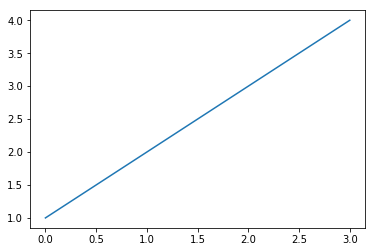

In [2]:
groups = db.collections.aggregate([{'$group':{_id:'$MATCH_EXP_JOBGLIDEIN_ResourceName',total:'$count'}}])
x = [g['_id'] for g in groups]
y = [g['total'] for g in groups]
plt.plot(x,y)